In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

file_path = '/churn_prediction.xlsx'
df = pd.read_excel(file_path)
df.head()


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,52869,0,20.0,Mobile Phone,3,7.0,E wallet,Female,4.0,4,Fashion,5,Married,3,0,26.0,5.0,16.0,NaN,229.53
1,52942,0,13.0,Computer,1,9.0,Cash on Delivery,Female,4.0,4,Fashion,3,Single,2,0,26.0,11.0,NaN,9.0,234.38
2,52972,0,16.0,Mobile Phone,3,7.0,Debit Card,Male,3.0,4,Laptop & Accessory,3,Divorced,3,0,26.0,5.0,12.0,7.0,174.07
3,53125,0,5.0,Mobile Phone,1,16.0,Debit Card,Male,3.0,4,Fashion,4,Married,3,0,26.0,2.0,2.0,9.0,231.48
4,53367,0,9.0,Mobile Phone,1,28.0,Debit Card,Female,3.0,4,Laptop & Accessory,2,Divorced,3,1,26.0,1.0,2.0,8.0,165.14


##**Overview Data**

###Check info & missing values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

&#8594; Có missing values

###Check duplicated values:

In [5]:
df.duplicated().unique()

array([False])

### Check imbalanced:

In [6]:
label_ratio = df['Churn'].value_counts(normalize=True)
label_ratio

,proportion
Churn,
0,0.831616
1,0.168384


## **Define type of data**

In [7]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [8]:
cat_cols = df.select_dtypes(include=['object'])
num_cols = df.select_dtypes(exclude=['object'])

In [9]:
cat_cols.columns

Index(['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender',
       'PreferedOrderCat', 'MaritalStatus'],
      dtype='object')

In [10]:
num_cols.columns

Index(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

##**EDA**

####Thay thế những giá trị có cùng nghĩa

In [11]:
df['PreferredLoginDevice'].replace('Mobile Phone', 'Phone', inplace=True)
df['PreferredPaymentMode'].replace('COD', 'Cash on Delivery', inplace=True)
df['PreferredPaymentMode'].replace('CC', 'Credit Card', inplace=True)
df['PreferedOrderCat'].replace('Mobile Phone', 'Mobile', inplace=True)

###Numberic Features

####Check Correlation

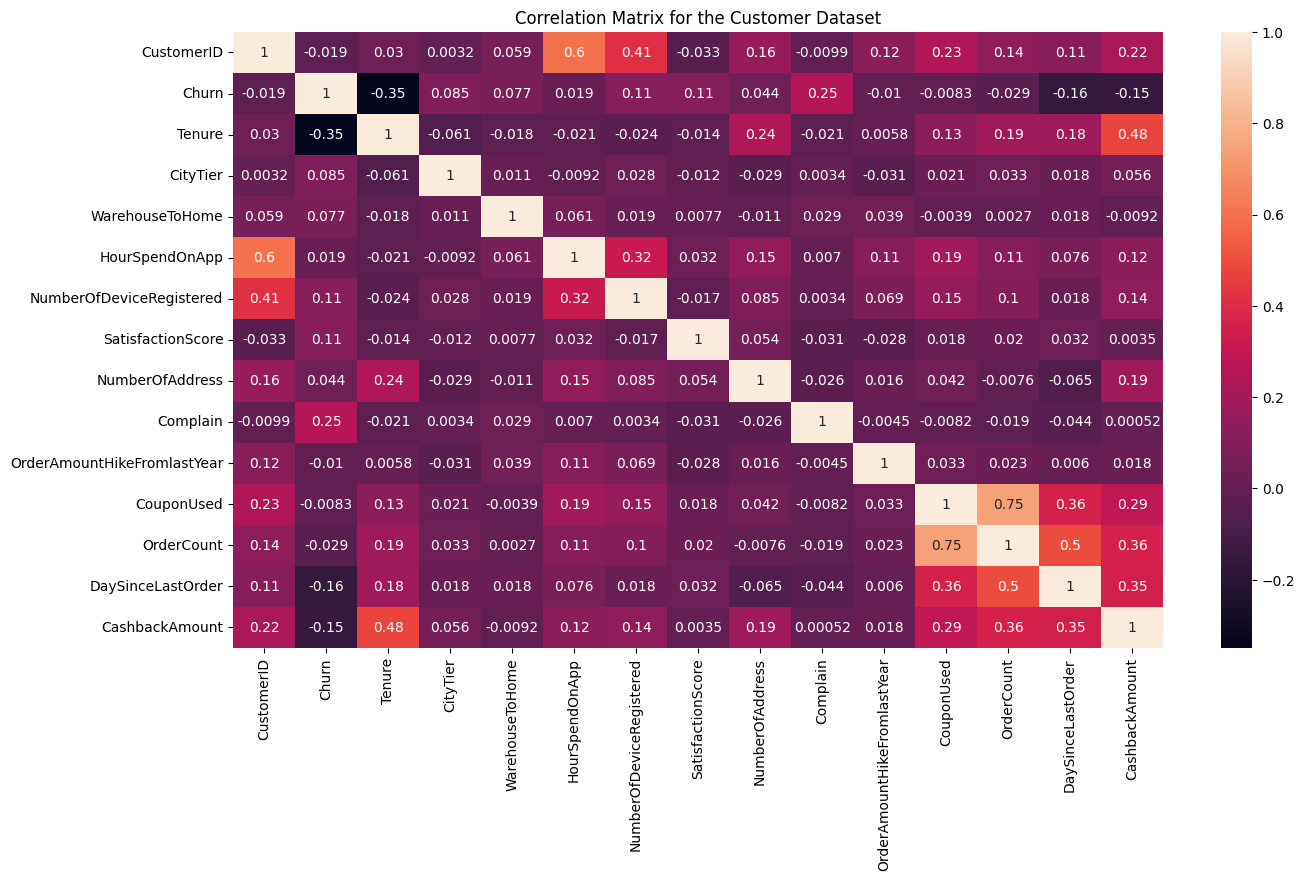

In [12]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Correlation Matrix for the Customer Dataset")
plt.show()

&#8594; Hầu như các biến số ko ảnh hưởng đến Churn


<Axes: xlabel='Churn', ylabel='Tenure'>

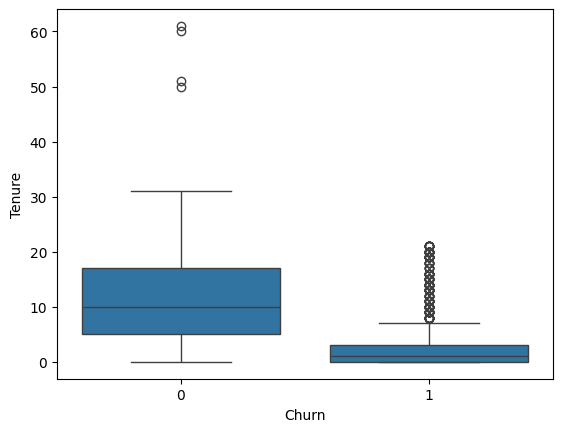

In [13]:
#Thời gian gắn bó
sns.boxplot(data=df, x='Churn',y='Tenure')

&#8594; Khách hàng có thời hạn sử dụng từ 0-5 tháng cho thấy tỷ lệ churn cao hơn.

<Axes: xlabel='Churn', ylabel='Complain'>

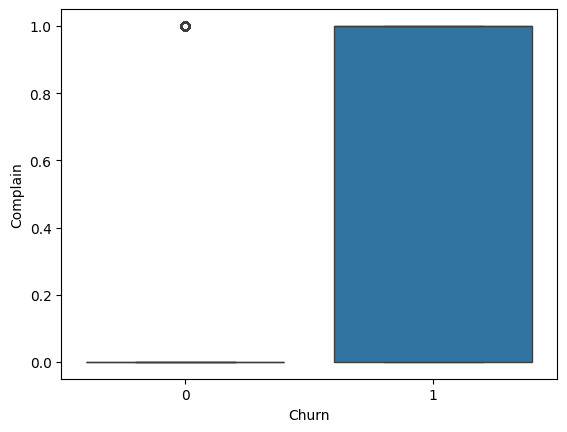

In [14]:
#Có than phiền hay không?
sns.boxplot(data=df, x='Churn',y='Complain')

&#8594; Toàn bộ khách hàng đã rời bỏ đều có Complain

### Category Features


In [15]:
def count_percentage_cc(df, column, target, count):

    churn = df[df[target]==1].groupby(column)[[count]].nunique().reset_index().sort_values(ascending=False, by = count)
    not_churn = df[df[target]==0].groupby(column)[[count]].nunique().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = churn.merge(not_churn, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'churn',count+'_y':'not_churn'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['churn']/(cate_df['churn']+cate_df['not_churn'])

    return cate_df

In [16]:
gender_df = count_percentage_cc(df,'Gender','Churn', 'CustomerID')
gender_df.sort_values(by=['%','churn'], ascending = False)

,Gender,churn,not_churn,%
1,Male,600,2784,0.177305
0,Female,348,1898,0.154942


&#8594; Nam giới có khả năng rời bỏ cao hơn

In [17]:
#marital status
marital_df = count_percentage_cc(df,'MaritalStatus','Churn','CustomerID')
marital_df.sort_values(by=['%','churn'], ascending = False)

,MaritalStatus,churn,not_churn,%
2,Single,480,1316,0.267261
0,Divorced,124,724,0.146226
1,Married,344,2642,0.115204


&#8594; Khách hàng chưa kết hôn có tỉ lệ rời bỏ cao nhất

In [18]:
logindevice_df = count_percentage_cc(df,'PreferredLoginDevice','Churn','CustomerID')
logindevice_df.sort_values(by=['%','churn'], ascending = False)


,PreferredLoginDevice,churn,not_churn,%
0,Computer,324,1310,0.198286
1,Phone,624,3372,0.156156


&#8594; Khách hàng sử dụng máy tính để đăng nhập có tỷ lệ hủy đăng ký cao hơn so với những người sử dụng điện thoại.


In [19]:
payment_df = count_percentage_cc(df,'PreferredPaymentMode','Churn','CustomerID')
payment_df.sort_values(by=['%','churn'], ascending = False)

,PreferredPaymentMode,churn,not_churn,%
0,Cash on Delivery,128,386,0.249027
3,E wallet,140,474,0.228013
4,UPI,72,342,0.173913
2,Debit Card,356,1958,0.153846
1,Credit Card,252,1522,0.142052


&#8594; Với hơn 20%, thanh toán khi nhận hàng và sử dụng ví điện tử cho thấy tỷ lệ churn cao nhất

In [20]:
cat_df = count_percentage_cc(df,'PreferedOrderCat','Churn','CustomerID')
cat_df.sort_values(by=['%','churn'], ascending = False)

,PreferedOrderCat,churn,not_churn,%
3,Mobile,570,1510,0.274038
0,Fashion,128,698,0.154964
2,Laptop & Accessory,210,1840,0.102439
4,Others,20,244,0.075758
1,Grocery,20,390,0.048780


&#8594;Danh mục Mobile có tỷ lệ khách hàng rời bỏ cao nhất, với gần 1/3 khách hàng.

&#8594;Ngược lại thì những người mua sắm hàng tạp hoá có vẻ trung thành hơn.


###Conculsion

- Những hành vi của churned users
  - Khách hàng rời bỏ thường sử dụng máy tính để truy cập ứng dụng hơn
  - Phần lớn khách hàng phàn nàn và có trạng thái độc thân có tỷ lệ rời cao

  - Khách hàng rời bỏ khi chỉ mới sử dụng dịch vụ được vài tháng đầu
  - Phân loại Mobile và Fashion có tỉ lệ rời bỏ cao hơn
- Đề xuất
  - Cải thiện trải nghiệm trên thiết bị máy tính: Tối ưu hóa về giao diện và tốc độ có thể là một yếu tố giúp giữ chân khách hàng.

  - Chăm sóc khách hàng và giải quyết khiếu nại: đa số khách hàng rời bỏ sau khi có khiếu nại. Cải thiện dịch vụ khách hàng, cung cấp các giải pháp nhanh chóng và hiệu quả khi có vấn đề phát sinh.

###EDA

In [21]:
df.isnull().sum()

,0
CustomerID,0
Churn,0
Tenure,264
PreferredLoginDevice,0
CityTier,0
WarehouseToHome,251
PreferredPaymentMode,0
Gender,0
HourSpendOnApp,255
NumberOfDeviceRegistered,0


In [22]:
def missing_values_table(df, null_name=False):
    null_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[null_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[null_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if null_name:
        return null_columns

null_columns = missing_values_table(df, null_name=True)

                             n_miss  ratio
DaySinceLastOrder               307   5.45
OrderAmountHikeFromlastYear     265   4.71
Tenure                          264   4.69
OrderCount                      258   4.58
CouponUsed                      256   4.55
HourSpendOnApp                  255   4.53
WarehouseToHome                 251   4.46


&#8594; Những cột này đều là dữ liệu số, phải check outliers trong Median

In [23]:
def outlier_thresholds(df, col_name, q1=0.05, q3=0.95):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(df, col_name):
    low_limit, up_limit = outlier_thresholds(df, col_name)
    if df[(df[col_name] > up_limit) | (df[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

CustomerID False
Churn False
Tenure False
CityTier False
WarehouseToHome True
HourSpendOnApp False
NumberOfDeviceRegistered False
SatisfactionScore False
NumberOfAddress False
Complain False
OrderAmountHikeFromlastYear False
CouponUsed True
OrderCount False
DaySinceLastOrder True
CashbackAmount False


&#8594;Xử lí Outliers

In [24]:
def replace_with_thresholds(df, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(df, variable, q1=0.05, q3=0.95)
    df.loc[(df[variable] < low_limit), variable] = low_limit
    df.loc[(df[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df,col)
for col in num_cols:
    print(col, check_outlier(df, col))

CustomerID False
Churn False
Tenure False
CityTier False
WarehouseToHome False
HourSpendOnApp False
NumberOfDeviceRegistered False
SatisfactionScore False
NumberOfAddress False
Complain False
OrderAmountHikeFromlastYear False
CouponUsed False
OrderCount False
DaySinceLastOrder False
CashbackAmount False


&#8594; Không còn outliers &#8594; Có thể thay thế missing values của cột dữ liệu số bằng Median

In [25]:
df["DaySinceLastOrder"].fillna(df["DaySinceLastOrder"].median(), inplace=True)
df["OrderAmountHikeFromlastYear"].fillna(df["OrderAmountHikeFromlastYear"].median(), inplace=True)
df["Tenure"].fillna(df["Tenure"].median(), inplace=True)
df["OrderCount"].fillna(df["OrderCount"].median(), inplace=True)
df["CouponUsed"].fillna(df["CouponUsed"].median(), inplace=True)
df["HourSpendOnApp"].fillna(df["HourSpendOnApp"].median(), inplace=True)
df["WarehouseToHome"].fillna(df["WarehouseToHome"].median(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   float64
 1   Churn                        5630 non-null   float64
 2   Tenure                       5630 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5630 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5630 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   float64
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

##**Feature Engineering & Transforming**

In [26]:
list_columns_to_drop = ['CustomerID','NumberOfAddress']
df_drop = df.drop(columns = list_columns_to_drop)
cate_columns = df_drop.loc[:, df_drop.dtypes == object].columns.tolist()

encoded_df = pd.get_dummies(df_drop, columns = cate_columns,dtype = int)
encoded_df.shape

(5630, 30)

In [27]:
encoded_df.head()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,Complain,OrderAmountHikeFromlastYear,CouponUsed,...,Gender_Female,Gender_Male,PreferedOrderCat_Fashion,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Others,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0.0,20.0,3,7.0,4.0,4.0,5,0.0,26.0,5.0,...,1,0,1,0,0,0,0,0,1,0
1,0.0,13.0,1,9.0,4.0,4.0,3,0.0,26.0,11.0,...,1,0,1,0,0,0,0,0,0,1
2,0.0,16.0,3,7.0,3.0,4.0,3,0.0,26.0,5.0,...,0,1,0,0,1,0,0,1,0,0
3,0.0,5.0,1,16.0,3.0,4.0,4,0.0,26.0,2.0,...,0,1,1,0,0,0,0,0,1,0
4,0.0,9.0,1,28.0,3.0,4.0,2,1.0,26.0,1.0,...,1,0,0,0,1,0,0,1,0,0


##**Model Training**

####Chia data set

In [28]:
from sklearn.model_selection import train_test_split
x=encoded_df.drop('Churn', axis = 1)
y=encoded_df[['Churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_temp, x_val, y_temp, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42)

print(f"Number data of train set: {len(x_train)}")
print(f"Number data of validate set: {len(x_val)}")
print(f"Number data of test set: {len(x_test)}")

Number data of train set: 3941
Number data of validate set: 1379
Number data of test set: 1379


####Chuẩn hoá dữ liệu

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

####Apply Model

In [30]:
from sklearn.linear_model import LogisticRegression

clf_logis = LogisticRegression(random_state = 0)
clf_logis.fit(x_train_scaled, y_train)

y_pred_val = clf_logis.predict(x_val_scaled)
y_pred_train = clf_logis.predict(x_train_scaled)


In [31]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=15, random_state=0, n_estimators = 100)

clf_rand.fit(x_train_scaled, y_train)

y_ranf_pre_train = clf_rand.predict(x_train_scaled)
y_ranf_pre_val = clf_rand.predict(x_val_scaled)

##**Model Evaluation**

In [32]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

####Logistic Regression

In [33]:
balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_accuracy_val = balanced_accuracy_score(y_val, y_pred_val)
print(balanced_accuracy_train,balanced_accuracy_val)

0.7127891025430219 0.7126691833509351


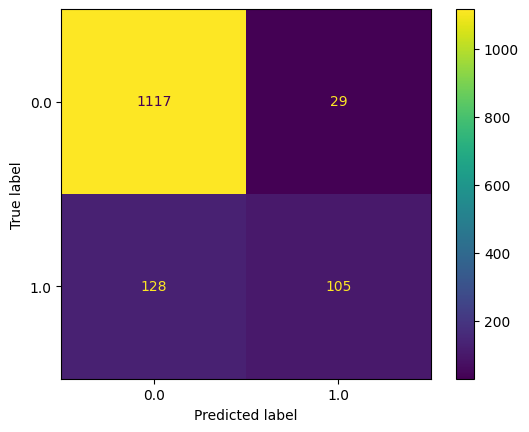

In [34]:
cm = confusion_matrix(y_val, y_pred_val, labels=clf_logis.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_logis.classes_)
disp.plot()

In [35]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_val))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_val))

# Độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred_val)
print(f"\nĐộ chính xác của mô hình: {accuracy * 100:.2f}%")

Confusion Matrix:
[[1050  107]
 [ 195   27]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1157
         1.0       0.20      0.12      0.15       222

    accuracy                           0.78      1379
   macro avg       0.52      0.51      0.51      1379
weighted avg       0.74      0.78      0.76      1379


Độ chính xác của mô hình: 78.10%


####Random Forest

In [36]:
balanced_accuracy_train = balanced_accuracy_score(y_train, y_ranf_pre_train)
balanced_accuracy_val = balanced_accuracy_score(y_val, y_ranf_pre_val)
print(balanced_accuracy_train,balanced_accuracy_val)

1.0 1.0


In [37]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_ranf_pre_val))

print("\nClassification Report:")
print(classification_report(y_val, y_ranf_pre_val))

accuracy = accuracy_score(y_val, y_ranf_pre_val)
print(f"\nĐộ chính xác của mô hình: {accuracy * 100:.2f}%")

Confusion Matrix:
[[1146    0]
 [   0  233]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1146
         1.0       1.00      1.00      1.00       233

    accuracy                           1.00      1379
   macro avg       1.00      1.00      1.00      1379
weighted avg       1.00      1.00      1.00      1379


Độ chính xác của mô hình: 100.00%


##**Hyperparameter Tuning**

In [38]:
from sklearn.model_selection import GridSearchCV
# Xác định các params để GridSearch chạy qua thử (nếu code chạy lâu quá, có thể giảm bớt số lượng params lại)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
# Ở đây mình dùng scoring là balanced_accuracy, mọi người có thể tùy chỉnh tùy vào mục đích model của mn nhé
grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(x_test, y_test)
print("Test set accuracy: ", accuracy)

Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test set accuracy:  1.0


1.0


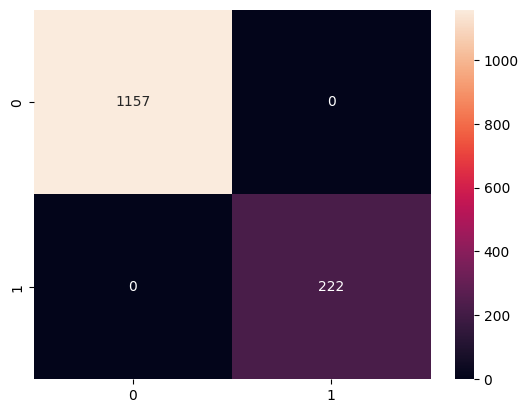

In [39]:
print(f1_score(y_test, best_model.predict(x_test)))
sns.heatmap(confusion_matrix(y_test, best_model.predict(x_test)), annot=True, fmt="g")
plt.show()

##**Customer Segmentation**

In [40]:
# Lọc ra các khách hàng đã rời bỏ
churned_users = encoded_df[encoded_df['Churn'] == 1]
churned_users.shape

(948, 30)

####Dimension Reduction

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
pca.fit(churned_users)
PCA_ds = pd.DataFrame(pca.transform(churned_users), columns=(["col1","col2", "col3",'col4','col5',"col6","col7","col8", "col9","col10","col11", "col12","col13",'col14','col15']))
PCA_ds

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15
0,-17.016753,1.435313,-2.409334,10.213775,-1.211934,-1.327788,0.169518,0.890100,0.866075,-0.169153,-1.162028,0.055504,-0.210930,-0.244229,-1.000666
1,-17.035263,1.451885,-2.425021,10.201386,-1.555194,-0.912910,0.101945,0.117227,1.151441,-0.284764,-1.191852,0.000721,-0.224943,-0.167624,-1.023000
2,-41.746444,0.130564,6.519354,9.300998,-1.902737,-0.671022,0.334983,0.311716,0.121860,-0.220332,-0.934230,-0.023656,-0.158991,-0.762050,-0.879521
3,-41.764954,0.147137,6.503666,9.288608,-2.245997,-0.256144,0.267410,-0.461157,0.407226,-0.335944,-0.964054,-0.078439,-0.173004,-0.685445,-0.901854
4,25.212925,-2.233943,-4.429952,9.731531,0.870097,2.781243,-1.181732,1.514767,1.407949,0.013458,-0.606312,-1.185081,0.217971,0.429404,0.451447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,157.904397,-11.511865,10.355019,1.620619,3.918488,-3.326066,1.370195,-1.819380,0.755527,-1.645994,-0.292325,-0.478007,1.107679,0.096668,0.399069
944,152.873647,-10.314330,-2.152399,1.126266,-2.532780,7.171085,-0.077722,0.554184,1.380339,0.968668,-0.730011,0.589644,0.609660,-0.062786,-0.369216
945,160.424709,-0.384070,-4.854627,0.339209,4.418678,-3.560554,-0.049345,-6.126663,1.981362,-2.614782,-0.451314,0.347233,-0.500986,-0.344769,-0.348902
946,157.941417,-11.545009,10.386394,1.645399,4.605008,-4.155821,1.505341,-0.273634,0.184795,-1.414772,-0.232677,-0.368442,1.135704,-0.056541,0.443736


In [42]:
pca.explained_variance_ratio_

array([9.16967820e-01, 4.25407535e-02, 1.70416593e-02, 8.63423805e-03,
       7.14562696e-03, 2.62849867e-03, 1.08226528e-03, 8.54732613e-04,
       6.18754945e-04, 5.74716005e-04, 3.25738012e-04, 2.61190121e-04,
       2.50863319e-04, 2.17861811e-04, 1.75018703e-04])

####Choose K-means

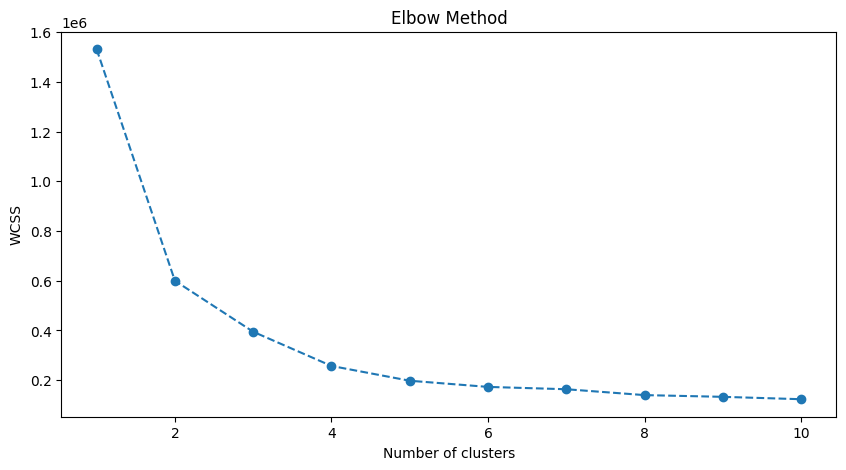

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Sử dụng phương pháp Elbow để chọn số lượng cụm phù hợp
ss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(PCA_ds)
    ss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(10,5))
plt.plot(range(1, max_clusters+1), ss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

&#8594; Chọn  k = 4


####Apply K-Means:

In [44]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
predicted_labels = kmeans.fit_predict(PCA_ds)

# Lọc ra các khách hàng đã rời bỏ để phân cụm
churn_df = df[df['Churn'] == 1]

# Thêm nhãn dự đoán vào DataFrame
PCA_ds['clusters']=predicted_labels
churn_df['clusters']=predicted_labels

In [45]:
churn_df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,clusters
7,53583.0,1.0,1.0,Computer,1,17.0,Credit Card,Female,4.0,5.0,...,4,Single,3.0,1.0,26.0,2.0,2.0,1.0,143.59,1
24,55053.0,1.0,1.0,Computer,1,17.0,Credit Card,Female,4.0,5.0,...,4,Single,3.0,1.0,26.0,1.0,2.0,1.0,143.59,1
40,50768.0,1.0,9.0,Computer,1,16.0,Credit Card,Female,3.0,4.0,...,4,Single,2.0,1.0,25.0,1.0,1.0,0.0,118.59,1
58,52238.0,1.0,9.0,Computer,1,16.0,Credit Card,Female,3.0,4.0,...,4,Single,2.0,1.0,25.0,0.0,1.0,0.0,118.59,1
68,52834.0,1.0,1.0,Computer,1,14.0,Debit Card,Male,4.0,6.0,...,3,Single,3.0,1.0,25.0,2.0,2.0,7.0,185.74,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5469,53286.0,1.0,21.0,Phone,1,9.0,Debit Card,Male,3.0,4.0,...,4,Single,9.0,1.0,15.0,6.0,14.0,9.0,317.46,0
5494,53604.0,1.0,9.0,Phone,3,9.0,E wallet,Female,4.0,6.0,...,4,Single,4.0,1.0,15.0,1.0,2.0,12.0,313.24,0
5531,54206.0,1.0,5.0,Phone,1,19.0,Cash on Delivery,Female,3.0,4.0,...,3,Married,3.0,0.0,15.0,2.0,16.0,9.0,320.45,0
5571,54756.0,1.0,21.0,Phone,1,9.0,Debit Card,Male,3.0,4.0,...,4,Single,9.0,1.0,15.0,8.0,14.0,9.0,317.46,0


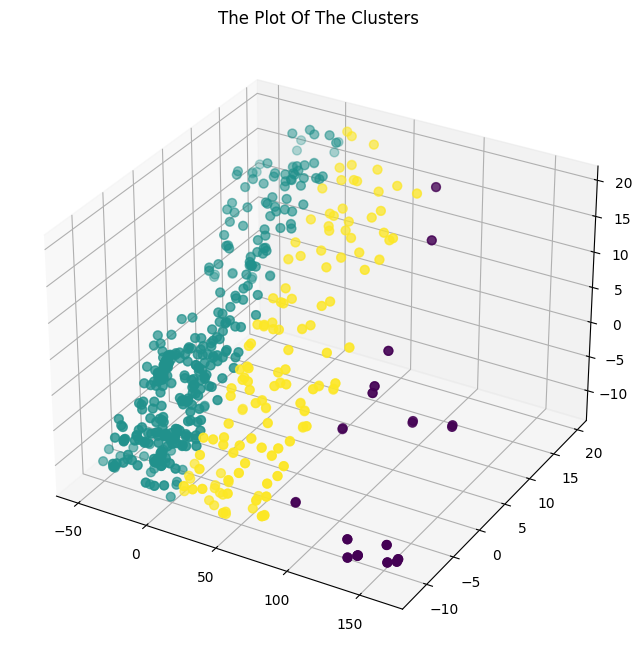

In [46]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'], PCA_ds['col2'], PCA_ds['col2'], s=40, c=PCA_ds["clusters"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

####Evaluating Model:

In [47]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(PCA_ds, predicted_labels)
print(sil_score)

0.5341180243625774


### Feature Importances

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=2, random_state=0)

clf_rand.fit(x_train, y_train)
y_ranf_pre_train = clf_rand.predict(x_train)
y_ranf_pre_test = clf_rand.predict(x_test)

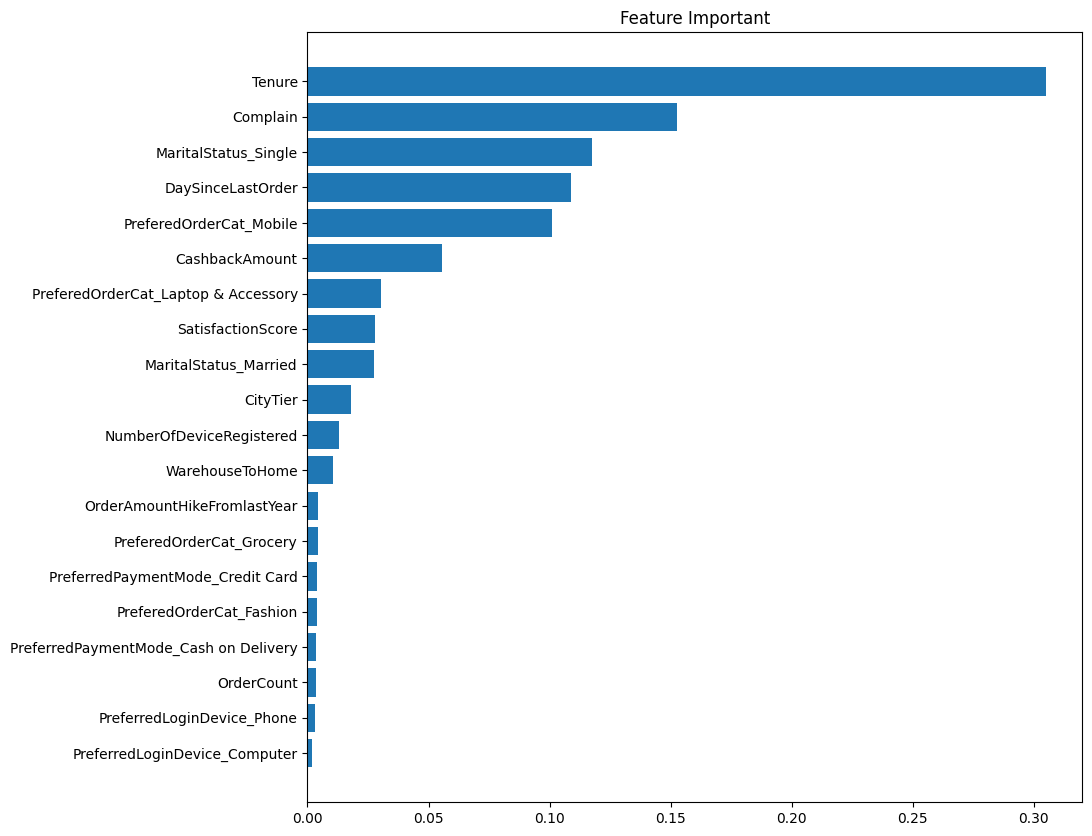

In [49]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_test.columns, clf_rand.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()

# Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')

# Show plot
plt.show()

Based on the model's feature importance, the top three features influencing a customer's churn probability are:

- **Customer Tenure:** Customers with shorter tenures are more likely to churn, as they may not have developed loyalty or satisfaction with the service yet.
- **Customer Complaints:** As expected, customers who have filed complaints show a higher churn rate compared to those without any complaints, indicating dissatisfaction with the service.
- **Marital Status:** Single customers have a higher churn rate compared to other groups, potentially indicating different usage patterns or service expectations.

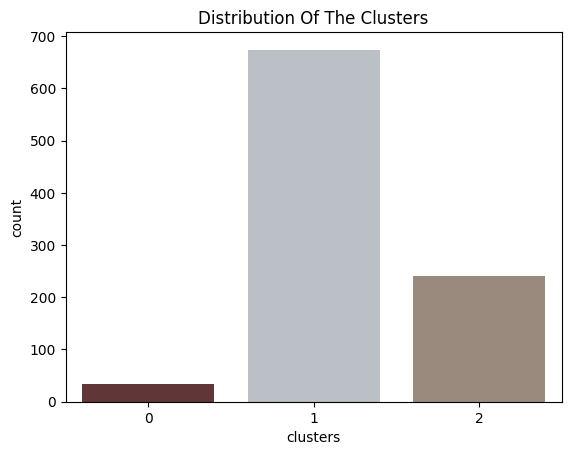

In [51]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=churn_df["clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

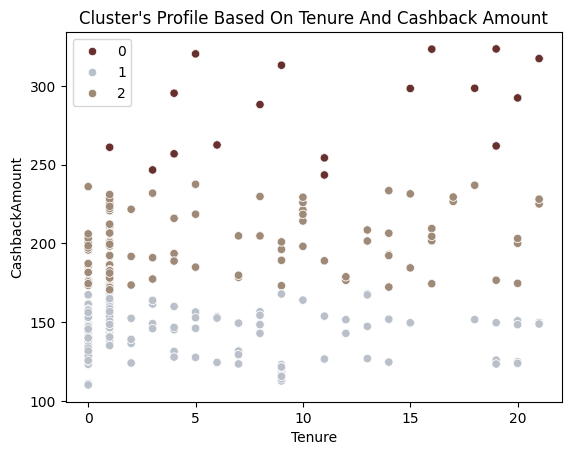

In [53]:
pl = sns.scatterplot(data = churn_df,x=churn_df["Tenure"], y=churn_df["CashbackAmount"],hue=churn_df["clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Tenure And Cashback Amount")
plt.legend()
plt.show()

- **Cluster 0** (dark brown): Customers with higher tenure (above 10 years) and higher cashback amounts. This group seems highly loyal and may expect premium rewards or higher cashback offers.
- **Cluster 1** (light blue): These customers have relatively low tenure and moderate cashback amounts. They may be newer customers, potentially attracted by entry-level promotions.
- **Cluster 2** (light brown): This group falls somewhere between Cluster 0 and 1, with varied tenures but generally moderate cashback amounts. They may be regular buyers looking for occasional deals.

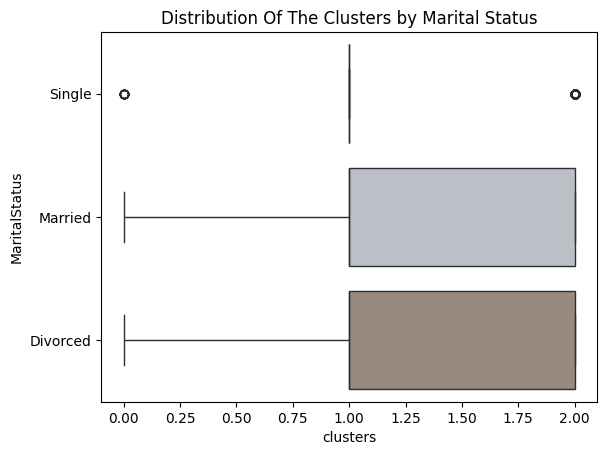

In [58]:
pl = sns.boxplot(data = churn_df,x=churn_df["clusters"], y=churn_df["MaritalStatus"], palette= pal)
pl.set_title("Distribution Of The Clusters by Marital Status")
plt.show()

- **Single customers** (Cluster 0) seem to stand out as outliers in terms of churn risk and may benefit from personalized offers that drive engagement or create a stronger connection with the brand.
- **Married and Divorced customers** (Clusters 1 and 2) are more evenly distributed, suggesting they may already be receiving appropriate offers. However, targeted promotions related to family or household purchases could boost loyalty.

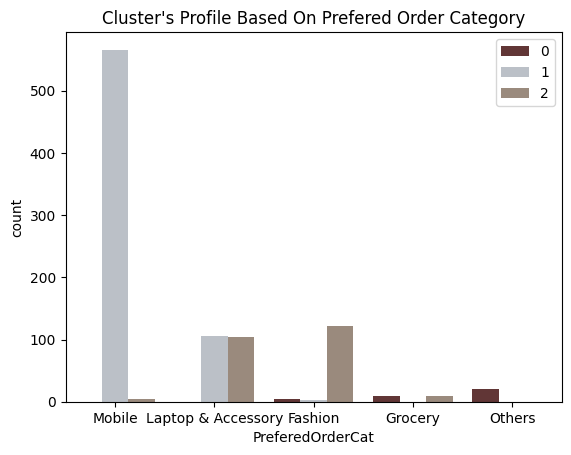

In [ ]:
pl = sns.countplot(data = churn_df,x=churn_df['PreferedOrderCat'],hue=churn_df['clusters'], palette= pal)
pl.set_title("Cluster's Profile Based On Prefered Order Category")
plt.legend()
plt.show()

- **Mobile** devices dominate the order category across all clusters, especially in Cluster 1 . This indicates that promotions around mobile devices and accessories could be highly effective in driving sales for this group.
- **Fashion and Grocery** categories also stand out for Clusters 1 and 2. Cross-category promotions (such as discounts on fashion items with mobile device purchases) might increase conversion rates.

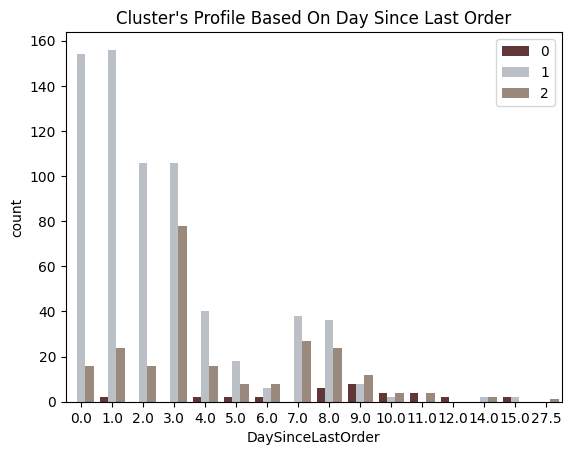

In [56]:
pl = sns.countplot(data = churn_df,x=churn_df['DaySinceLastOrder'],hue=churn_df['clusters'], palette= pal)
pl.set_title("Cluster's Profile Based On Day Since Last Order")
plt.legend()
plt.show()

- **Customers in Cluster 1** show the highest frequency of recent orders, suggesting they are the most engaged and responsive to new promotions.
- **Cluster 2** shows more variation, indicating the need for re-engagement campaigns (like limited-time discounts or loyalty bonuses) to prevent churn.

### **Recommendations:**

**1. Segment-Specific Promotions:**

- **Cluster 0 (High Loyalty, High Cashback):** Offer exclusive or premium rewards, such as higher cashback, early access to new products, or premium membership benefits.

- **Cluster 1 (New Customers):** Provide entry-level promotions, such as “Buy One, Get One Free” offers or introductory discounts to encourage repeat purchases.

- **Cluster 2 (Regular Buyers):** Focus on personalized offers based on purchase history and interest in specific categories (e.g., technology, fashion).

**2. Promotional Timing:**

- Use the insights from the **Days Since Last Order** data to offer time-sensitive deals, particularly targeting Cluster 2 for re-engagement.
- Align promotions around high-demand times for each cluster, ensuring that Cluster 1 receives frequent updates on new products.

**3. Personalized Messaging:**

- Utilize **marital status insights** to craft messaging tailored to specific segments. For example, single customers may respond better to individual-focused campaigns, while married customers could appreciate family-oriented promotions.

**4. Leverage Preferred Categories:**

- Create **category-specific campaigns** targeting high-demand items such as mobiles for Cluster 1 and offer bundle deals to increase average order value.
- Cross-sell between high-potential categories like Fashion and Groceries to promote variety.